### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import pandas as pd
import sys

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

In [2]:
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'

idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')

molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

### Torch settings

In [3]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 50

## Data

In [6]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

## Make PyTorch dataset
train = ds.MyDataset(dir=dir, scale = "norm")
test  = ds.MyDataset(dir=dir, scale = "norm", train = False)
 
print('total # of samples:',len(train)+len(test))
print('# training samples:',len(train))
print('# testing samples: ',len(test) )
print('            ratio: ',np.round(len(test)/(len(train)+len(test)),2))


total # of samples: 2997
# training samples: 2097
# testing samples:  900
            ratio:  0.3


In [7]:
## Make PyTorch tensor objects from the data set to train

kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True ,  **kwargs)
test_loader = DataLoader(dataset=test , batch_size=len(test) , shuffle=False,  **kwargs)


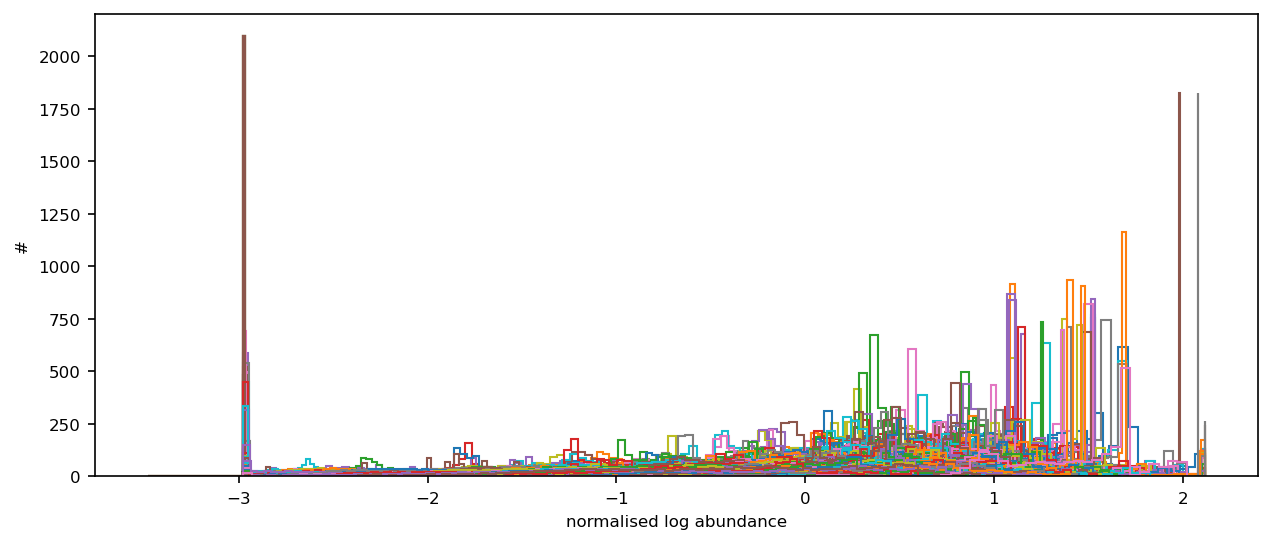

In [7]:
pl.plot_hist(train.df)

## Model 1

### hyperparameters

In [8]:
## Set up training hyperparams
lr = 1e-3                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'straight'

## Build model
encoder = ae.Encoder( input_dim, hidden_dim, latent_dim, nb_hidden=nb_hidden, type = type)
encoder.set_name('Encoder 1')
decoder = ae.Decoder(latent_dim, hidden_dim, output_dim, nb_hidden=nb_hidden, type = type)
decoder.set_name('Decoder 1')
model = ae.Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU
model.set_name('Model 1')

In [9]:
ae.overview(model)

Overview Model 1:

___________________________________

Encoder 1:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     324310

Decoder 1:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     324768


### Training & testing

In [10]:
## Training & validating model

loss_train_all, loss_test_all = tr.Train(model, lr, data_loader, test_loader, epochs, DEVICE)
x_test, x_test_hat, loss = tr.Test(model, test_loader, DEVICE)


Model 1:
	Epoch 50 complete! 	Average loss train:  0.006410625696714435 	Average loss test:  0.008095502853393555
DONE!

loss Model 1:  0.008095502853393555


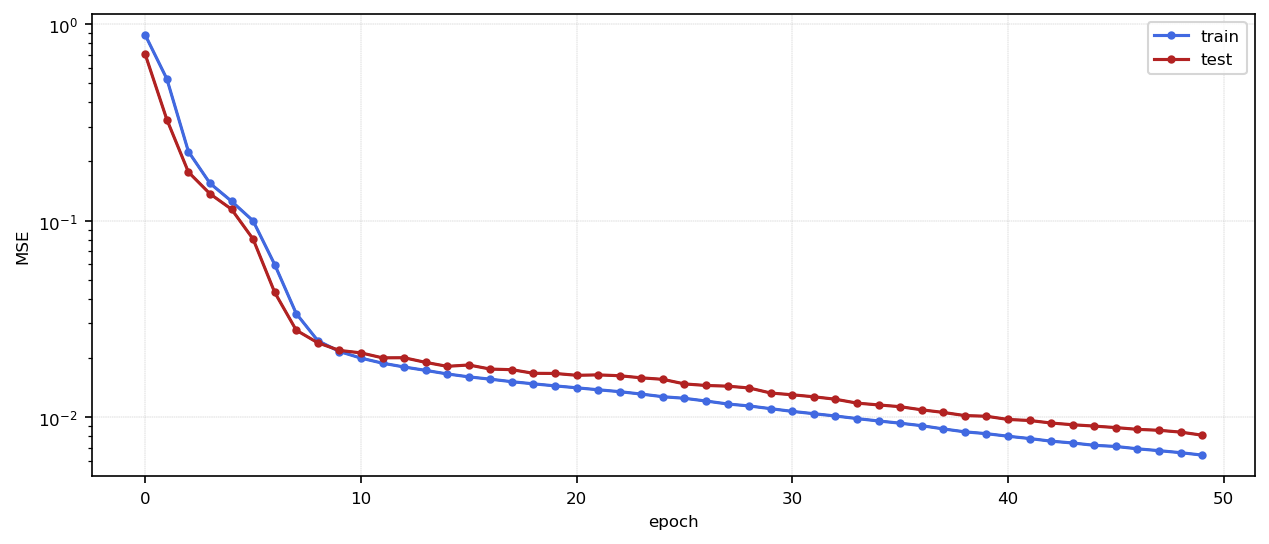

In [11]:
pl.plot_loss(loss_train_all, loss_test_all)

## Model 2 

### hyperparameters

In [16]:
## Set up training hyperparams
lr = 1e-3                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'decr'

## Build model
encoder = ae.Encoder( input_dim, hidden_dim, latent_dim, nb_hidden=nb_hidden, type = type)
encoder.set_name('Encoder 2')
decoder = ae.Decoder(latent_dim, hidden_dim, output_dim, nb_hidden=nb_hidden, type = type)
decoder.set_name('Decoder 2')
model2 = ae.Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU
model2.set_name('Model 2')

## Training & testing

In [18]:
## Training & validating model

loss_train_all2, loss_test_all2 = tr.Train(model2, lr, data_loader, test_loader, epochs, DEVICE)
x_test2, x_test_hat2, loss2 = tr.Test(model2, test_loader, DEVICE)


Model 2:
	Epoch 50 complete! 	Average loss train:  0.007414865484904675 	Average loss test:  0.0092251012101769456
DONE!

loss Model 2:  0.009225101210176945


## Comparison of models

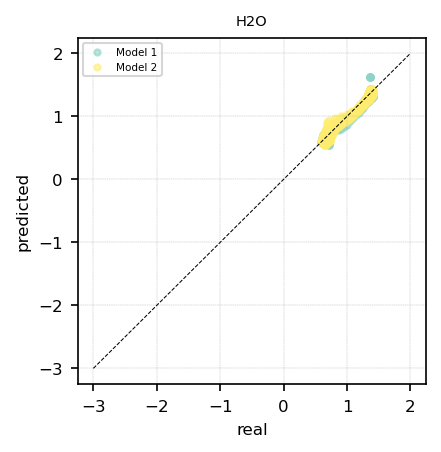

In [19]:
pl.plot_compare(x_test,[x_test_hat, x_test_hat2], [model, model2],molecs,'H2O')


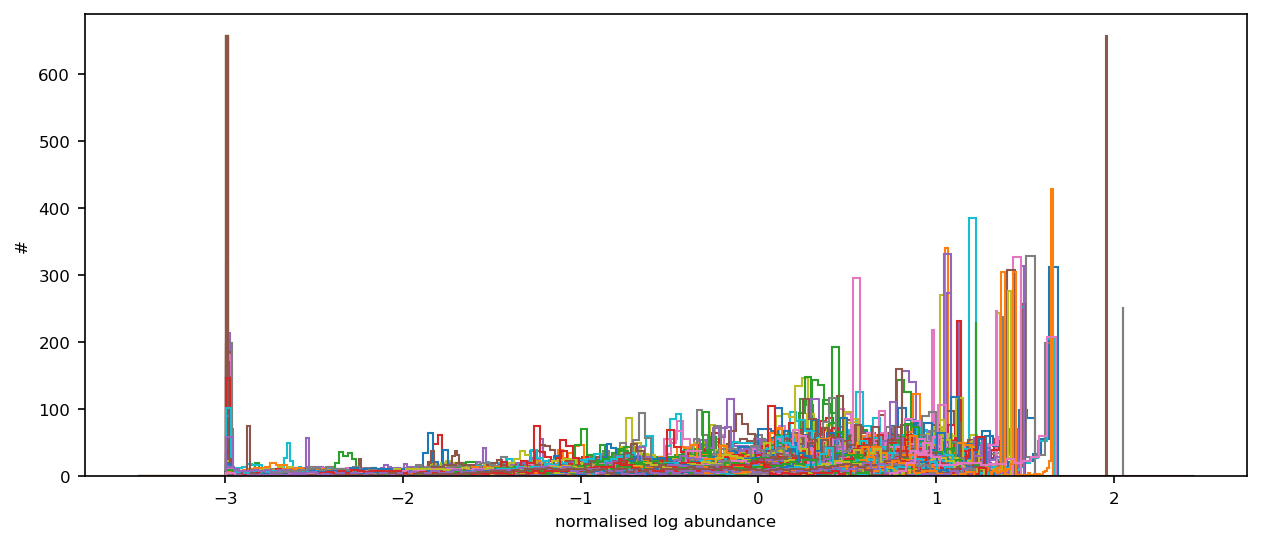

In [16]:
# pl.plot_hist(x_test)

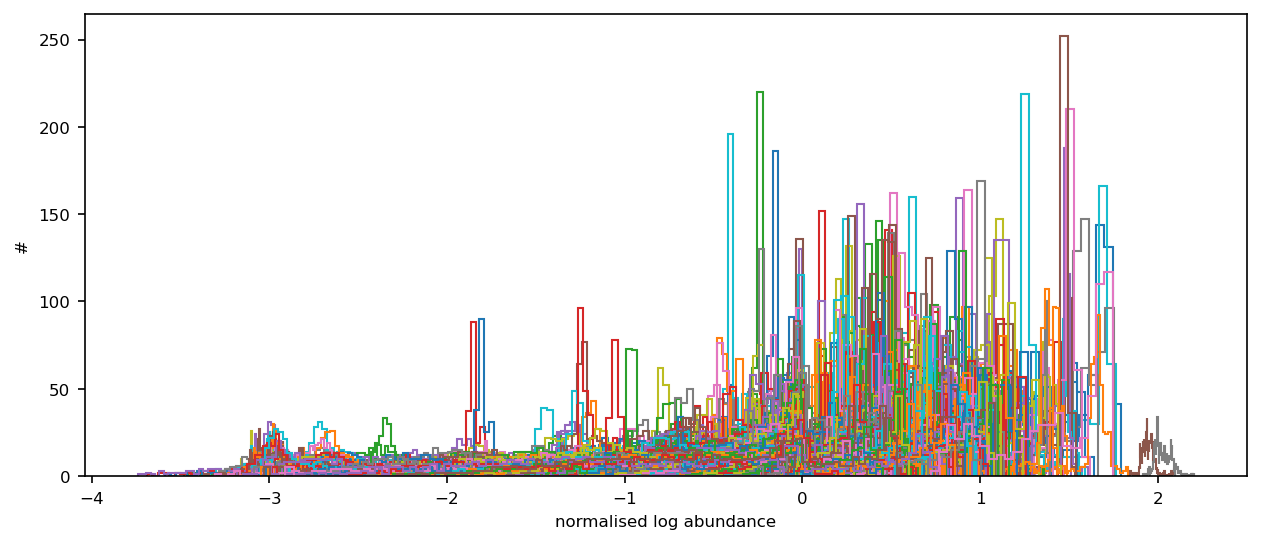

In [17]:
# pl.plot_hist(x_test_hat)

In [20]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

In [21]:
rad, real, pred = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')

In [22]:
rad, real, pred2 = tr.test_abundance_profile(dir_test, 'test', model2, DEVICE, kwargs, scale = 'norm')

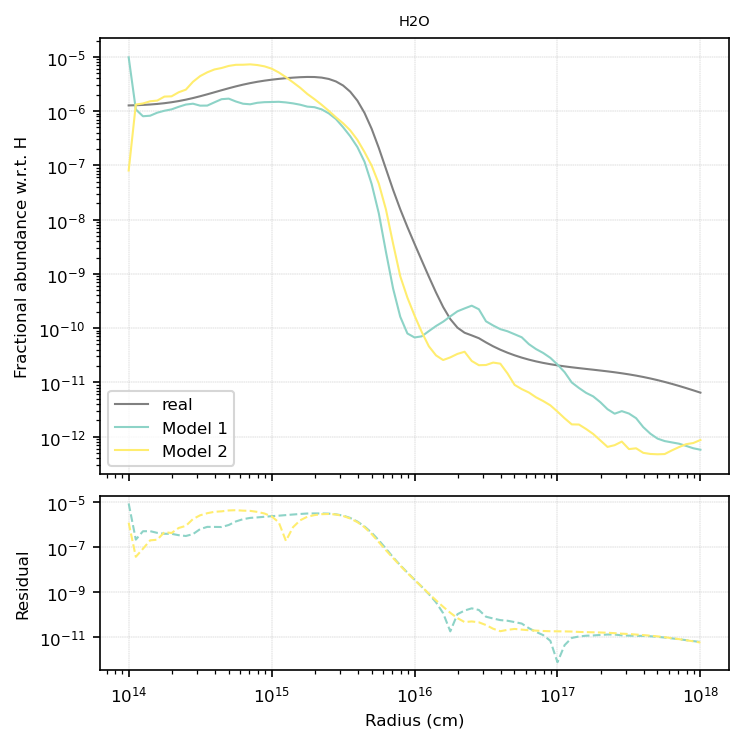

In [23]:
pl.plot_fracs_profile(rad, real, [pred, pred2], [model, model2], molecs, 'H2O')